In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [5]:
server = 'EFGSVR050\\NOVY'
database = 'Olist Case Study'
conn_str = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}')

# Load data using SQL queries
customers_query = "SELECT customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state FROM olist_customers_dataset"
orders_query = "SELECT order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date FROM olist_orders_dataset"
payments_query = "SELECT order_id, payment_sequential, payment_type, payment_installments, payment_value FROM olist_order_payments_dataset"
order_items_query = "SELECT order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value FROM olist_order_items_dataset"

# Execute queries and load data into dataframes
customers = pd.read_sql(customers_query, conn_str)
orders = pd.read_sql(orders_query, conn_str)
payments = pd.read_sql(payments_query, conn_str)
order_items = pd.read_sql(order_items_query, conn_str)

In [6]:
# Merge datasets
data = customers.merge(orders, on='customer_id', how='inner') \
                .merge(payments, on='order_id', how='inner') \
                .merge(order_items, on='order_id', how='inner')

data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e2db07183615dd1fd30115b590cda2b7,c631a16cbd5fabdc9c15f28e1ece5900,5541.0,sao paulo,SP,9b4b42fc4f3a0ff13e896d031a9723c8,delivered,2018-01-08 23:22:31,2018-01-10 14:51:28,2018-01-10 22:08:41,...,1.0,credit_card,10.0,108.51,1.0,e96a50fc74fa04fd6f23b324d87a1a81,bc2ac6b95e1accce9858528ee566c17e,2018-01-16 14:51:28,99.00,9.51
1,7d2ce17487f8378b620234f629e9f5d5,cc65d08fa1d799911f5237365ce38bcb,79822.0,dourados,MS,309a6726656b1ace9925bb760fc46b81,delivered,2017-09-03 22:14:32,2017-09-03 22:25:09,2017-09-04 16:57:13,...,1.0,credit_card,10.0,913.70,1.0,a3e4a417e7dab3de222f227781c2c291,5dceca129747e92ff8ef7a997dc4f8ca,2017-09-10 22:25:09,887.00,26.70
2,5a1c1e9fe3aa6fa5a2f1d9d86f2f9aeb,4287002812bf7576a9a1d6f3cb5746c1,5469.0,sao paulo,SP,7f2309408220014301685cdf123b4067,delivered,2018-06-09 18:45:40,2018-06-09 19:11:02,2018-06-11 14:08:00,...,1.0,credit_card,1.0,91.79,1.0,cc1cb33bcc814aeaa4631761a34bd23e,5d3bb11474a06bdc23fb9e89f1164ee0,2018-06-14 19:11:02,78.80,12.99
3,1e711e252c12c1ca4268a8b54d374e2e,28c9e96d57749798d454f3b4ee31e332,76160.0,sanclerlandia,GO,e6f93bd585302afc87091c7d85c21ffe,delivered,2017-06-18 20:45:37,2017-06-18 21:03:46,2017-06-22 09:33:10,...,1.0,credit_card,1.0,39.91,1.0,b0c1e71a37e29bd3d463eb93e4861c6a,1caf283236cd69af44cbc09a0a1e7d32,2017-06-22 21:03:46,21.99,17.92
4,b10fe33654a6d22ae6e87f3ed316b1dc,7e1013f7423cda110d3ccf6d6d544b8d,2367.0,sao paulo,SP,099d60cb800db65a72d355528bb7f41e,delivered,2018-05-08 22:56:28,2018-05-08 23:11:49,2018-05-09 11:43:00,...,1.0,credit_card,3.0,324.63,1.0,4621f88827b983332c2a833d49c2ae35,a3f0b55de503387383c7b1de3ad7f678,2018-05-17 23:11:49,219.90,104.73


In [7]:
# Convert date columns to datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])

In [10]:
# Select features for clustering
features = data[['customer_zip_code_prefix', 'payment_value', 'price']]

In [11]:
# Handle missing values
features.fillna(0, inplace=True)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

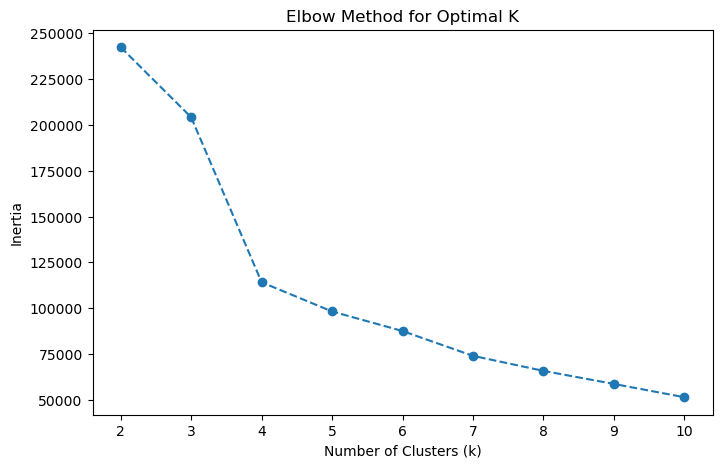

In [12]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
range_n_clusters = range(2, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [14]:
from sklearn.decomposition import PCA
# Choose optimal k (e.g., k=4 based on the Elbow plot)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2) #Reduce the dataset to 2 dimensions (principal components)
pca_result = pca.fit_transform(features_scaled)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

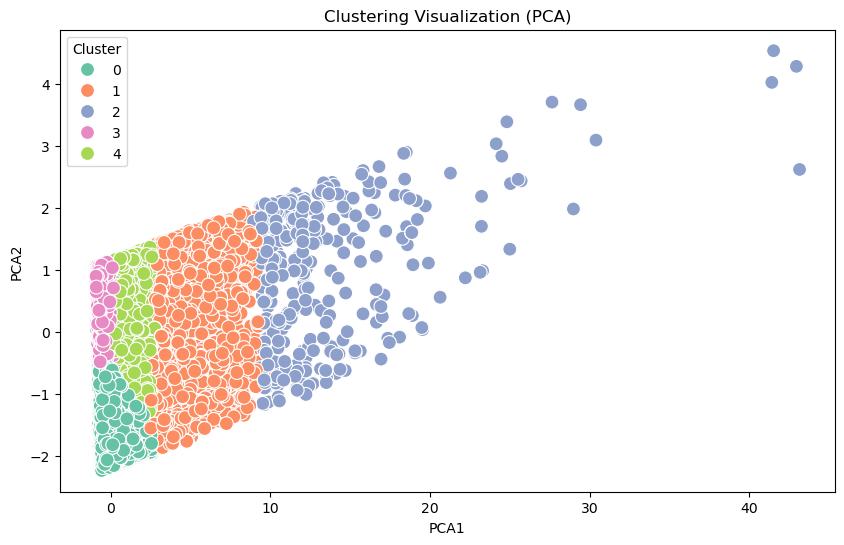

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data['PCA1'], 
    y=data['PCA2'], 
    hue=data['Cluster'], 
    palette='Set2', 
    s=100
)
plt.title('Clustering Visualization (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [16]:
# Save the clustered data
data.to_csv('customer_clustering_results.csv', index=False)
print("Clustering completed and saved to 'customer_clustering_results.csv'.")

Clustering completed and saved to 'customer_clustering_results.csv'.
